In [36]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os
from pathlib import Path

from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## HELPER FUNCTIONS

In [38]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def eval_model(model, data_loader, loss_fn, accuracy_fn,
               device):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

## GETTING DATA

In [39]:
DATA_PATH = Path("D:/PROGRAMMING/PYTHON/dataset/pizza_steak_sushi")

TRAIN_PATH = DATA_PATH / "train"
TEST_PATH = DATA_PATH / "test"

def walk_through_dir(dir_path):

    for dirpath , dirname , filenames in os.walk(dir_path):
        print(f'There are {len(dirname)} directories , {len(filenames)} files in {dirpath}')

walk_through_dir(DATA_PATH)

There are 2 directories , 0 files in D:\PROGRAMMING\PYTHON\dataset\pizza_steak_sushi
There are 3 directories , 0 files in D:\PROGRAMMING\PYTHON\dataset\pizza_steak_sushi\test
There are 0 directories , 25 files in D:\PROGRAMMING\PYTHON\dataset\pizza_steak_sushi\test\pizza
There are 0 directories , 19 files in D:\PROGRAMMING\PYTHON\dataset\pizza_steak_sushi\test\steak
There are 0 directories , 31 files in D:\PROGRAMMING\PYTHON\dataset\pizza_steak_sushi\test\sushi
There are 3 directories , 0 files in D:\PROGRAMMING\PYTHON\dataset\pizza_steak_sushi\train
There are 0 directories , 78 files in D:\PROGRAMMING\PYTHON\dataset\pizza_steak_sushi\train\pizza
There are 0 directories , 75 files in D:\PROGRAMMING\PYTHON\dataset\pizza_steak_sushi\train\steak
There are 0 directories , 72 files in D:\PROGRAMMING\PYTHON\dataset\pizza_steak_sushi\train\sushi



    Random Image Path: D:\PROGRAMMING\PYTHON\dataset\pizza_steak_sushi\train\steak\443210.jpg,
    Image Class: steak,
    Image Height: 512,
    Image Width: 512



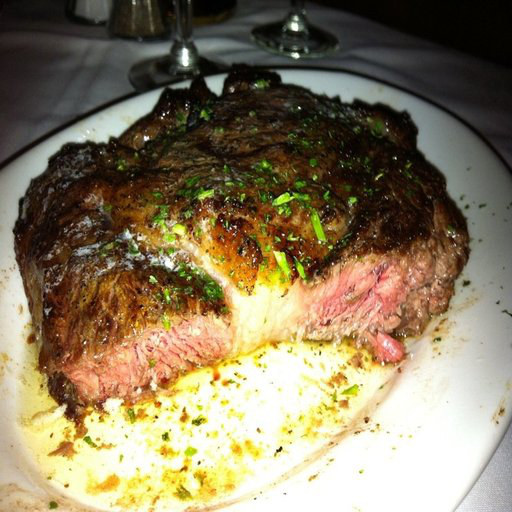

In [40]:
# random.seed(42)
img_path_list = list(DATA_PATH.glob("*/*/*.jpg"))

random_img = random.choice(img_path_list)
img_class = random_img.parent.stem

img = Image.open(random_img)
print(f"""
    Random Image Path: {random_img},
    Image Class: {img_class},
    Image Height: {img.height},
    Image Width: {img.width}
""")

img_np_array = np.array(img)
img

## TRANSFORMING DATA

In [55]:
data_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),

    transforms.RandomHorizontalFlip(p = 0.5),

    transforms.ToTensor()
])

data_transform_augmentation = transforms.Compose([
    transforms.Resize(size = (64,64)),

    transforms.TrivialAugmentWide(num_magnitude_bins=31),

    transforms.ToTensor()
])

data_transform_simple = transforms.Compose([
    transforms.Resize(size = (64,64)),

    transforms.ToTensor()
])


data_transform(img).shape


torch.Size([3, 64, 64])

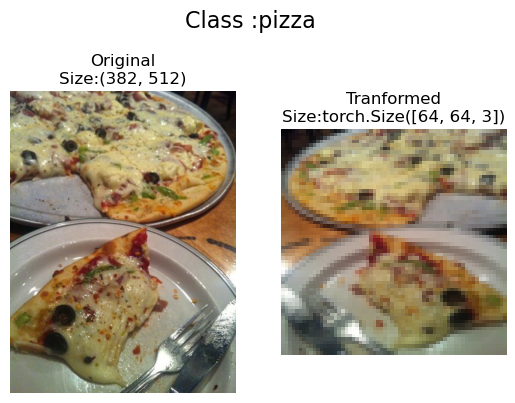

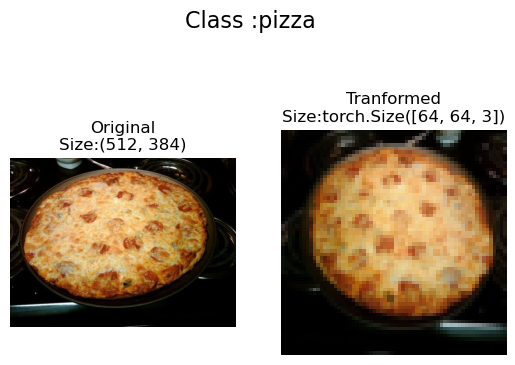

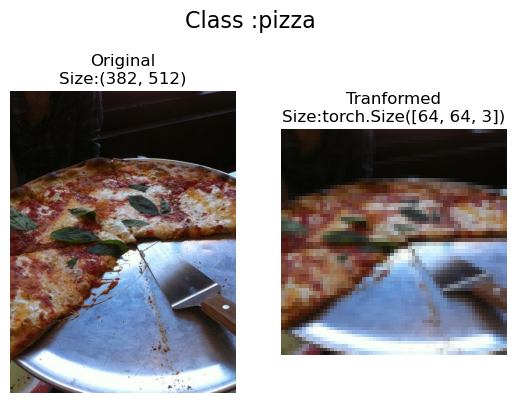

In [42]:
def plot_transformed_img(img_paths , transform , n = 3 , seed = None):
    if seed:
        random.seed(seed)

    random_img_paths = random.sample(img_paths , k = n)

    for img_path in random_img_paths:
        with Image.open(img_path) as f:
            fig , ax = plt.subplots(1 , 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize:{f.size}")
            ax[0].axis(False)

            tx_img = transform(f).permute(1,2,0)
            ax[1].imshow(tx_img)
            ax[1].set_title(f"Tranformed\nSize:{tx_img.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class :{img_path.parent.stem}" , fontsize = 16)

plot_transformed_img(img_path_list , data_transform)

In [57]:
train_data = datasets.ImageFolder(
    root = TRAIN_PATH , 
    transform = data_transform,
    target_transform = None,
    
)

test_data = datasets.ImageFolder(
    root = TEST_PATH , 
    transform = data_transform,
    target_transform = None,
    
)

class_names = train_data.classes


# AUGMENTED DATASETS

train_augmented_data = datasets.ImageFolder(
    root = TRAIN_PATH,
    transform = data_transform_augmentation,
    target_transform = None
)

test_augmented_data = datasets.ImageFolder(
    root = TEST_PATH,
    transform = data_transform_simple,
    target_transform = None
)

In [63]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data , 
                              batch_size = BATCH_SIZE ,
                              shuffle = True)

test_dataloader = DataLoader(test_data , 
                              batch_size = BATCH_SIZE ,
                              shuffle = False)

# AUGMENTED DATALOADER
train_augmented_dataloader = DataLoader(train_augmented_data , 
                              batch_size = BATCH_SIZE ,
                              shuffle = True)

test_augmented_dataloader = DataLoader(test_augmented_data , 
                              batch_size = BATCH_SIZE ,
                              shuffle = False) 

Dataset ImageFolder
    Number of datapoints: 225
    Root location: D:\PROGRAMMING\PYTHON\dataset\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

## CREATING AND TRAINING A MODEL

In [45]:
class TinyVGG(nn.Module):
    def __init__(self , input_shape , hidden_units , output_shape) -> None:
        super().__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),

            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2)
                        
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      padding = 1),
            nn.ReLU(),

            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
                        
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*16*16 , out_features = output_shape) 
        )

    def forward(self , X):
        X = self.conv_layer1(X)
        X = self.conv_layer2(X)
        
        return self.classifier(X)

In [46]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = TinyVGG(3 , 10 , len(class_names)).to(device)
model

TinyVGG(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [47]:
image_batch , label_batch = next(iter(train_dataloader))

model(image_batch.to(device))

tensor([[0.0559, 0.0615, 0.0358],
        [0.0625, 0.0659, 0.0359],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0375],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0348],
        [0.0620, 0.0599, 0.0370],
        [0.0607, 0.0628, 0.0387],
        [0.0637, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0690, 0.0330],
        [0.0557, 0.0570, 0.0357],
        [0.0630, 0.0649, 0.0391],
        [0.0628, 0.0633, 0.0369],
        [0.0608, 0.0626, 0.0375],
        [0.0616, 0.0645, 0.0372],
        [0.0711, 0.0668, 0.0418],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0634, 0.0628, 0.0367],
        [0.0627, 0.0645, 0.0397],
        [0.0630, 0.0655, 0.0398],
        [0.0652, 0.0585, 0.0418],
        [0.0639, 0.0597, 0.0395],
        [0.0664, 0.0672, 0.0393],
        [0.0697, 0.0631, 0.0402],
        [0.062

## TRAINING AND TESTING LOOP

In [48]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc



def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc




In [49]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model.parameters() , lr = 0.001)

In [50]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [51]:
EPOCHS = 10

model_results = train(model , train_dataloader , test_dataloader , optimizer , loss_fn , EPOCHS )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1104 | train_acc: 0.3008 | test_loss: 1.0995 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1128 | train_acc: 0.2773 | test_loss: 1.0695 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1118 | train_acc: 0.2617 | test_loss: 1.0906 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0900 | train_acc: 0.4258 | test_loss: 1.1148 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0925 | train_acc: 0.3047 | test_loss: 1.1364 | test_acc: 0.2812
Epoch: 6 | train_loss: 1.1041 | train_acc: 0.4414 | test_loss: 1.1403 | test_acc: 0.3438
Epoch: 7 | train_loss: 1.0593 | train_acc: 0.5781 | test_loss: 1.0497 | test_acc: 0.5227
Epoch: 8 | train_loss: 0.9994 | train_acc: 0.4453 | test_loss: 0.9793 | test_acc: 0.4119
Epoch: 9 | train_loss: 0.9964 | train_acc: 0.4844 | test_loss: 1.0837 | test_acc: 0.4233
Epoch: 10 | train_loss: 0.8887 | train_acc: 0.4922 | test_loss: 0.9787 | test_acc: 0.4527


In [52]:
def plot_loss_curves(result_dict):
    loss = result_dict["train_loss"]
    test_loss = result_dict["test_loss"]
    acc = result_dict["train_acc"]
    test_acc = result_dict["test_acc"]

    num_epochs = range(len(loss))

    plt.figure(figsize = (15,7))

    plt.subplot(1,2,1)

    plt.plot(num_epochs , loss , label = "Train Loss")
    plt.plot(num_epochs , test_loss , label = "Test Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1,2,2)

    plt.plot(num_epochs , acc , label = "Train Acc")
    plt.plot(num_epochs , test_acc , label = "Test Acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()

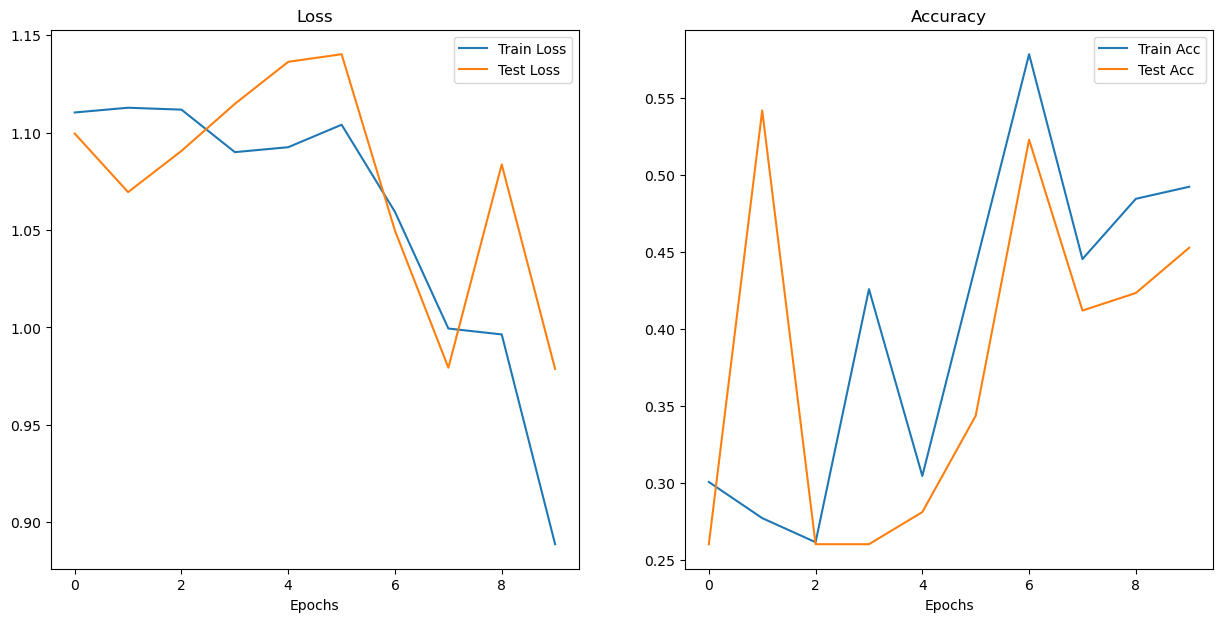

In [53]:
plot_loss_curves(model_results)

## TINYVGG MODEL BUT USING AUGMENTED DATA

In [69]:
model_1 = TinyVGG(input_shape = 3 , hidden_units = 10 , output_shape = len(class_names)).to(device)

loss_fn_1 = nn.CrossEntropyLoss()

optimizer_1 = torch.optim.Adam(params = model_1.parameters() , lr = 0.001)

In [72]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS_1 = 10

model_1_results = train(model = model_1 , train_dataloader = train_augmented_dataloader , test_dataloader = test_augmented_dataloader,
                        optimizer = optimizer_1 , loss_fn = loss_fn_1 , epochs = EPOCHS_1)



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9333 | train_acc: 0.5625 | test_loss: 1.1722 | test_acc: 0.3021
Epoch: 2 | train_loss: 1.0148 | train_acc: 0.5000 | test_loss: 1.1218 | test_acc: 0.2803
Epoch: 3 | train_loss: 1.0340 | train_acc: 0.4570 | test_loss: 1.0533 | test_acc: 0.3627
Epoch: 4 | train_loss: 1.0226 | train_acc: 0.4648 | test_loss: 0.9580 | test_acc: 0.5246
Epoch: 5 | train_loss: 0.9873 | train_acc: 0.4297 | test_loss: 1.0348 | test_acc: 0.3125
Epoch: 6 | train_loss: 1.0660 | train_acc: 0.3594 | test_loss: 0.9870 | test_acc: 0.5038
Epoch: 7 | train_loss: 0.9412 | train_acc: 0.5391 | test_loss: 1.1133 | test_acc: 0.3125
Epoch: 8 | train_loss: 0.9230 | train_acc: 0.5508 | test_loss: 1.1868 | test_acc: 0.3021
Epoch: 9 | train_loss: 0.9240 | train_acc: 0.5703 | test_loss: 1.1185 | test_acc: 0.3011
Epoch: 10 | train_loss: 0.8807 | train_acc: 0.5859 | test_loss: 1.0630 | test_acc: 0.3722


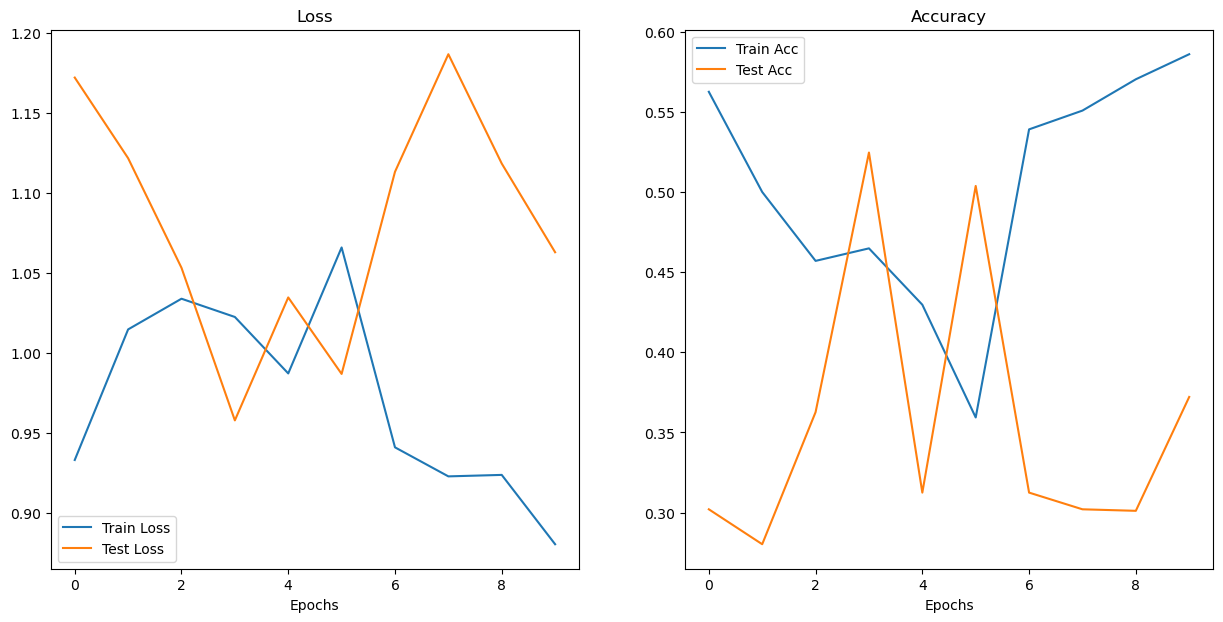

In [73]:
plot_loss_curves(model_1_results)